<h1>Machine Learning - Test NoteBook</h1>

<h2>All import </h2>

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




<h3> - Read CSV with pandas </h">

In [5]:
df = pd.read_csv('datasetAvantML.csv')
max_per_class = 5000
for rating in range(1,6):
    df_rating = df[df['Rating'] == rating]
    if len(df_rating) > max_per_class:
        df = df.drop(df_rating.index[max_per_class:])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 25139
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Content          25000 non-null  object 
 1   Rating           25000 non-null  int64  
 2   likes            25000 non-null  int64  
 3   Year_Month       25000 non-null  object 
 4   polarity         25000 non-null  float64
 5   subjectivity     25000 non-null  float64
 6   locations        1080 non-null   object 
 7   polarity_words   24003 non-null  object 
 8   word_count       25000 non-null  int64  
 9   days_diff        25000 non-null  int64  
 10  Content_cleaned  24921 non-null  object 
 11  punctuation      25000 non-null  object 
 12  tokenized        25000 non-null  object 
 13  lemmatized       25000 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 2.9+ MB


In [7]:
# Étape 1: Créer une colonne temporaire qui compte chaque type de ponctuation
punctuation_stats = df["punctuation"].apply(lambda x: Counter(x))

# Étape 2 : Ajouter les nouvelles colonnes tout en conservant 'punctuation'
df["punctuation_count"] = punctuation_stats.apply(lambda x: sum(x.values()))  # Total des signes de ponctuation
df["exclamation_count"] = punctuation_stats.apply(lambda x: x.get("!", 0))
df["question_count"] = punctuation_stats.apply(lambda x: x.get("?", 0))
df["comma_count"] = punctuation_stats.apply(lambda x: x.get(",", 0))

# Étape 3 : Calcul de la corrélation entre la ponctuation et le 'Rating'
correlation = df["punctuation_count"].corr(df["Rating"])
print(f"📊 Corrélation entre 'punctuation_count' et 'Rating' : {correlation}")

# Vérification finale
print(df[["punctuation", "punctuation_count", "exclamation_count", "question_count", "comma_count"]].head())

df["Content_cleaned"] = df["Content_cleaned"].fillna("") # Remplacer les valeurs manquantes par une chaîne vide

📊 Corrélation entre 'punctuation_count' et 'Rating' : -0.29485120083726246
            punctuation  punctuation_count  exclamation_count  question_count  \
0            [',', '.']                 10                  0               0   
1                 ['.']                  5                  0               0   
2  ['’', '.', '.', '.']                 20                  0               0   
3            ['’', '.']                 10                  0               0   
4       ['’', '.', '.']                 15                  0               0   

   comma_count  
0            2  
1            0  
2            3  
3            1  
4            2  


In [8]:
df.drop(["tokenized","Content_cleaned","punctuation_count","locations"], axis=1, inplace=True)


In [ ]:
df.loc[df["lemmatized"] == "[]", ["Content", "lemmatized"]].to_clipboard()

In [10]:
df.drop(df.index[df["lemmatized"] == "[]"], axis=0, inplace=True) # On drop les lignes lemmatisées vides


<h3>Vectorized</h3>

In [20]:
df_binary = df.copy()
df_binary["Rating_binary"] = df_binary["Rating"].apply(lambda x: 1 if x >= 4 else 0)

X_bin = df_binary.drop(columns=["Rating", "Rating_binary"])  # Supprimer l'ancienne note
y_bin = df_binary["Rating_binary"]  # Utiliser la note binaire comme target



In [33]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)


In [ ]:


# Initialisation du vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=3, stop_words="english")

# Transformation en matrice TF-IDF
tfidf_matrix = vectorizer_tfidf.fit_transform(X_train_bin["lemmatized"])
tfidf_matrix_test = vectorizer_tfidf.transform(X_test_bin["lemmatized"])
# Conversion en liste et stockage dans `vectorized`
X_train_bin["vectorized"] = list(tfidf_matrix.toarray())
X_test_bin["vectorized"] = list(tfidf_matrix_test.toarray())

# Vérification
print(X_train_bin[["vectorized"]].head())
print(X_test_bin[["vectorized"]].head())


for dfi in [X_train_bin, X_test_bin]:
    dfi["vectorized_sum"] = dfi["vectorized"].apply(lambda x: sum(x))
    print(dfi[["vectorized_sum"]].head(10))

    total_tfidf_sum = sum(dfi["vectorized_sum"])
    print(f"📌 Somme totale de toutes les valeurs TF-IDF : {total_tfidf_sum}")

    print(f"📌 Nombre de lignes avec une somme TF-IDF nulle : {(dfi['vectorized_sum'] == 0).sum()} / {len(dfi)}")

print(type(X_train_bin["vectorized"].iloc[0]))  # Doit être <class 'list'>
print(X_train_bin["vectorized"].iloc[0])  # Doit afficher une liste de nombres

X_vectorized_train = np.vstack(X_train_bin["vectorized"].values)
X_vectorized_test = np.vstack(X_test_bin["vectorized"].values)

print("📌 Shape de X_vectorized test:", X_vectorized_test.shape)
print("📌 Shape de X_vectorized train:", X_vectorized_train.shape)

# Sélectionner uniquement les features numériques pertinentes
X_train_b = X_train_bin[["polarity", "subjectivity", "word_count", "days_diff", "vectorized_sum"]].values
X_test_b = X_test_bin[["polarity", "subjectivity", "word_count", "days_diff", "vectorized_sum"]].values
# Concaténer les features textuelles vectorisées avec les autres variables
X_train_bin = np.hstack((X_vectorized_train, X_train_b))
X_test_bin = np.hstack((X_vectorized_test, X_test_b))
# X_final = X_vectorized

print("📌 Shape de X_final :", X_train_bin.shape)  # Doit être (n_samples, 28082 + nb_features_numériques)

                                              vectorized
8579   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
16813  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
16801  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11168  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
24836  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                              vectorized
11701  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9288   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5334   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3592   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
23486  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
       vectorized_sum
8579         2.927546
16813        1.000000
16801        4.406274
11168        7.657906
24836        3.769047
12682        3.582412
854          3.853678
24944        1.414208
22800        2.158206
11091        2.923559
📌 Somme totale de toutes les valeurs TF-IDF : 59582.61003944928
📌 Nombre d

In [11]:

y = df["Rating"].values  

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Rating"]), y, test_size=0.2, random_state=42)

In [ ]:


# Initialisation du vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=3, stop_words="english")

# Transformation en matrice TF-IDF
tfidf_matrix = vectorizer_tfidf.fit_transform(X_train["lemmatized"])
tfidf_matrix_test = vectorizer_tfidf.transform(X_test["lemmatized"])
# Conversion en liste et stockage dans `vectorized`
X_train["vectorized"] = list(tfidf_matrix.toarray())
X_test["vectorized"] = list(tfidf_matrix_test.toarray())

# Vérification
print(X_train[["vectorized"]].head())
print(X_test[["vectorized"]].head())

                                              vectorized
2629   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2116   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8069   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9237   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
15848  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                              vectorized
12612  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3053   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
24156  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4419   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4601   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [13]:
for dfi in [X_train, X_test]:
    dfi["vectorized_sum"] = dfi["vectorized"].apply(lambda x: sum(x))
    print(dfi[["vectorized_sum"]].head(10))

    total_tfidf_sum = sum(dfi["vectorized_sum"])
    print(f"📌 Somme totale de toutes les valeurs TF-IDF : {total_tfidf_sum}")

    print(f"📌 Nombre de lignes avec une somme TF-IDF nulle : {(dfi['vectorized_sum'] == 0).sum()} / {len(dfi)}")

       vectorized_sum
2629         1.000000
2116         3.038287
8069         3.246375
9237         3.924920
15848        1.721874
18676        6.223825
13256        3.774646
8879         2.113347
3491         2.851701
13901        1.672635
📌 Somme totale de toutes les valeurs TF-IDF : 59768.57111438049
📌 Nombre de lignes avec une somme TF-IDF nulle : 37 / 19924
       vectorized_sum
12612        1.920460
3053         2.566546
24156        1.979228
4419         2.412213
4601         1.406066
12370        2.850577
3989         3.519335
19511        2.992229
3808         1.725791
6030         1.413731
📌 Somme totale de toutes les valeurs TF-IDF : 14798.214669034383
📌 Nombre de lignes avec une somme TF-IDF nulle : 6 / 4981


In [14]:
print(type(X_train["vectorized"].iloc[0]))  # Doit être <class 'list'>
print(X_train["vectorized"].iloc[0])  # Doit afficher une liste de nombres

<class 'numpy.ndarray'>
[0. 0. 0. ... 0. 0. 0.]


In [15]:

# Convertir la colonne `vectorized` en un tableau NumPy correctement formaté
X_vectorized_train = np.vstack(X_train["vectorized"].values)
X_vectorized_test = np.vstack(X_test["vectorized"].values)

print("📌 Shape de X_vectorized test:", X_vectorized_test.shape)
print("📌 Shape de X_vectorized train:", X_vectorized_train.shape)

📌 Shape de X_vectorized test: (4981, 4042)
📌 Shape de X_vectorized train: (19924, 4042)


In [16]:
# Sélectionner uniquement les features numériques pertinentes
X_train = X_train[["polarity", "subjectivity", "word_count", "days_diff", "vectorized_sum"]].values
X_test = X_test[["polarity", "subjectivity", "word_count", "days_diff", "vectorized_sum"]].values
# Concaténer les features textuelles vectorisées avec les autres variables
X_train = np.hstack((X_vectorized_train, X_train))
X_test = np.hstack((X_vectorized_test, X_test))
# X_final = X_vectorized

print("📌 Shape de X_final :", X_train.shape)  # Doit être (n_samples, 28082 + nb_features_numériques)

📌 Shape de X_final : (19924, 4047)


<h3> Test ML </h3>

In [17]:
import mlflow
import mlflow.sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [18]:
# !mlflow ui --port 5001
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.autolog()

2025/03/06 20:31:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/06 20:31:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [ ]:
mlflow.set_experiment("SupplyChain - TrustPilot V2")

models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, verbose=1),
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, name)

        print(f"📌 {name} Accuracy: {accuracy:.4f}")

        print(classification_report(y_test, y_pred))

2025/03/06 20:31:19 INFO mlflow.tracking.fluent: Experiment with name 'SupplyChain - TrustPilot V2' does not exist. Creating a new experiment.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28407441
Epoch 3, change: 0.22963727
Epoch 4, change: 0.21197304
Epoch 5, change: 0.16941490
Epoch 6, change: 0.14244305
Epoch 7, change: 0.12350886
Epoch 8, change: 0.10932411
Epoch 9, change: 0.09733478
Epoch 10, change: 0.08785721
Epoch 11, change: 0.07999218
Epoch 12, change: 0.07338003
Epoch 13, change: 0.06771537
Epoch 14, change: 0.06281545
Epoch 15, change: 0.05854372
Epoch 16, change: 0.05476059
Epoch 17, change: 0.05143230
Epoch 18, change: 0.04844279
Epoch 19, change: 0.04576100
Epoch 20, change: 0.04334240
Epoch 21, change: 0.04113408
Epoch 22, change: 0.03912687
Epoch 23, change: 0.03728810
Epoch 24, change: 0.03560685
Epoch 25, change: 0.03404777
Epoch 26, change: 0.03260269
Epoch 27, change: 0.03126643
Epoch 28, change: 0.03003251
Epoch 29, change: 0.02886499
Epoch 30, change: 0.02778565
Epoch 31, change: 0.02677002
Epoch 32, change: 0.02582522
Epoch 33, change: 0.02492307
Epoch 34, change: 0.02407954
Epoch 35, change: 0.023

/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.4min finished
2025/03/06 20:35:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/baptiste/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


📌 Logistic Regression Accuracy: 0.3353
              precision    recall  f1-score   support

           1       0.45      0.30      0.36       978
           2       0.33      0.33      0.33      1026
           3       0.32      0.06      0.11      1016
           4       0.21      0.17      0.19       961
           5       0.35      0.81      0.48      1000

    accuracy                           0.34      4981
   macro avg       0.33      0.33      0.29      4981
weighted avg       0.33      0.34      0.29      4981



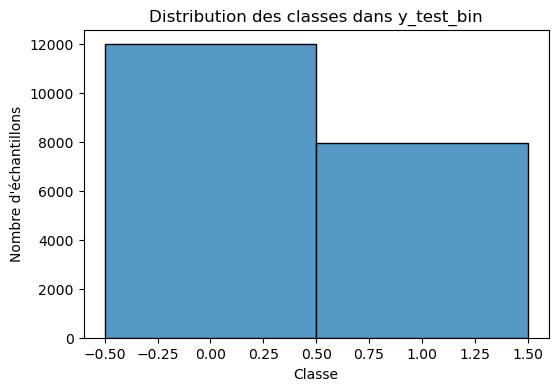

In [36]:
plt.figure(figsize=(6, 4))
sns.histplot(y_train_bin, bins=2, discrete=True)
plt.title("Distribution des classes dans y_test_bin")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.show()

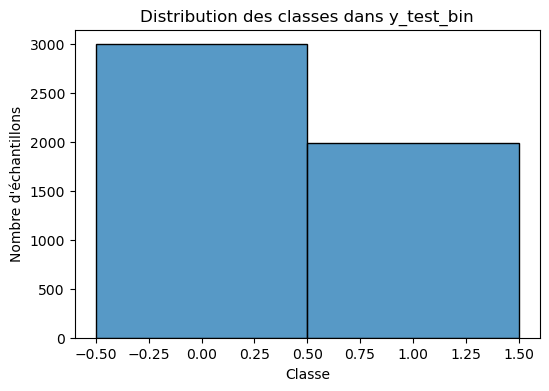

In [37]:

plt.figure(figsize=(6, 4))
sns.histplot(y_test_bin, bins=2, discrete=True)
plt.title("Distribution des classes dans y_test_bin")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.show()

In [ ]:
models = {
    "Logistic Regression - Binaire": LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, verbose=1),
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train_bin, y_train_bin)

        y_pred = model.predict(X_test_bin)
        accuracy = accuracy_score(y_test_bin, y_pred)

        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, name)

        print(f"📌 {name} Accuracy: {accuracy:.4f}")

        print(classification_report(y_test_bin, y_pred))

2025/03/06 20:41:35 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.16502499
Epoch 3, change: 0.14784075
Epoch 4, change: 0.13287080
Epoch 5, change: 0.13124108
Epoch 6, change: 0.12936841
Epoch 7, change: 0.12456749
Epoch 8, change: 0.11045575
Epoch 9, change: 0.09928707
Epoch 10, change: 0.09011103
Epoch 11, change: 0.08249065
Epoch 12, change: 0.07605767
Epoch 13, change: 0.07053973
Epoch 14, change: 0.06576497
Epoch 15, change: 0.06159095
Epoch 16, change: 0.05790692
Epoch 17, change: 0.05462736
Epoch 18, change: 0.05170163
Epoch 19, change: 0.04906300
Epoch 20, change: 0.04668239
Epoch 21, change: 0.04451416
Epoch 22, change: 0.04253779
Epoch 23, change: 0.04072603
Epoch 24, change: 0.03906087
Epoch 25, change: 0.03752044
Epoch 26, change: 0.03609475
Epoch 27, change: 0.03477471
Epoch 28, change: 0.03354776
Epoch 29, change: 0.03239915
Epoch 30, change: 0.03132576
Epoch 31, change: 0.03031824
Epoch 32, change: 0.02937508
Epoch 33, change: 0.02848819
Epoch 34, change: 0.02764701
Epoch 35, change: 0.026

/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished


📌 Logistic Regression - Binaire Accuracy: 0.7625
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3020
           1       0.71      0.66      0.69      1961

    accuracy                           0.76      4981
   macro avg       0.75      0.74      0.75      4981
weighted avg       0.76      0.76      0.76      4981



In [ ]:
models = {
    "Logistic Regression - Binaire - class_weight": LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, verbose=1, class_weight="balanced"),
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train_bin, y_train_bin)

        y_pred = model.predict(X_test_bin)
        accuracy = accuracy_score(y_test_bin, y_pred)

        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, name)

        print(f"📌 {name} Accuracy: {accuracy:.4f}")

        print(classification_report(y_test_bin, y_pred))

2025/03/06 20:48:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.40972246
Epoch 3, change: 0.27412297
Epoch 4, change: 0.20337783
Epoch 5, change: 0.16378643
Epoch 6, change: 0.13775060
Epoch 7, change: 0.11849235
Epoch 8, change: 0.10414167
Epoch 9, change: 0.09261810
Epoch 10, change: 0.08326785
Epoch 11, change: 0.07548647
Epoch 12, change: 0.06894953
Epoch 13, change: 0.06334547
Epoch 14, change: 0.05852832
Epoch 15, change: 0.05428543
Epoch 16, change: 0.05053849
Epoch 17, change: 0.04724607
Epoch 18, change: 0.04430258
Epoch 19, change: 0.04166199
Epoch 20, change: 0.03925916
Epoch 21, change: 0.03709870
Epoch 22, change: 0.03511393
Epoch 23, change: 0.03331165
Epoch 24, change: 0.03163381
Epoch 25, change: 0.03011894
Epoch 26, change: 0.02893565
Epoch 27, change: 0.02804696
Epoch 28, change: 0.02722103
Epoch 29, change: 0.02645023
Epoch 30, change: 0.02573207
Epoch 31, change: 0.02505784
Epoch 32, change: 0.02442717
Epoch 33, change: 0.02383578
Epoch 34, change: 0.02327336
Epoch 35, change: 0.022

/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished


📌 Logistic Regression - Binaire - class_weight Accuracy: 0.6804
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      2991
           1       0.57      0.84      0.68      1990

    accuracy                           0.68      4981
   macro avg       0.71      0.71      0.68      4981
weighted avg       0.73      0.68      0.68      4981



In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve

model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', thresholds=0.29280802607536316)
model_xgb.fit(X_train_bin, y_train_bin)

y_pred_proba = model_xgb.predict_proba(X_test_bin)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

conf_matrix = confusion_matrix(y_test_bin, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

print(f"Vrai négatif (TN): {tn}")
print(f"Faux négatif (FN): {fn}")

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Seuil optimal: {optimal_threshold}")

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

conf_matrix_optimal = confusion_matrix(y_test_bin, y_pred_optimal)
tn_optimal, fp_optimal, fn_optimal, tp_optimal = conf_matrix_optimal.ravel()

print(f"Vrai négatif (TN) avec seuil optimal: {tn_optimal}")
print(f"Faux négatif (FN) avec seuil optimal: {fn_optimal}")

2025/03/06 20:51:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd297ece22ad44fbcac506bdd7fb72e77', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/03/06 20:51:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


Vrai négatif (TN): 2729
Faux négatif (FN): 408
Seuil optimal: 0.29280802607536316
Vrai négatif (TN) avec seuil optimal: 2477
Faux négatif (FN) avec seuil optimal: 232


In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/03/06 21:11:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


🔹 Longueur de thresholds : 4836
🔹 Longueur de false_positives : 4836
🔹 Longueur de false_negatives : 4836


 98%|===================| 4881/4981 [00:19<00:00]        

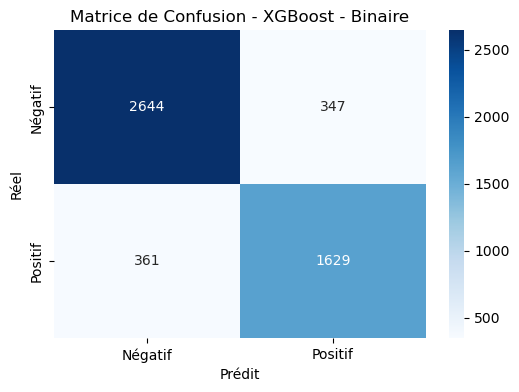

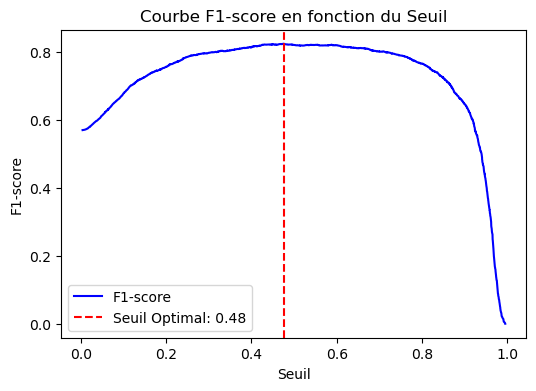

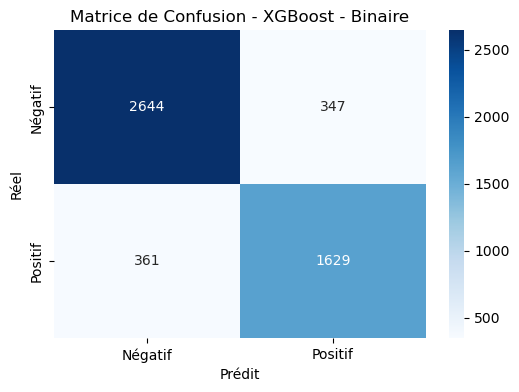

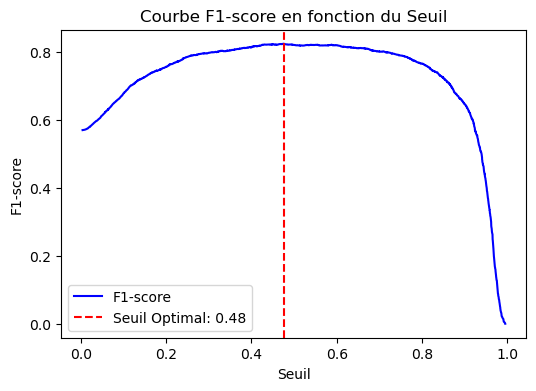

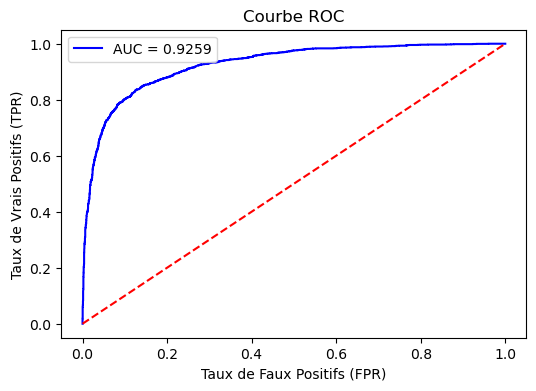

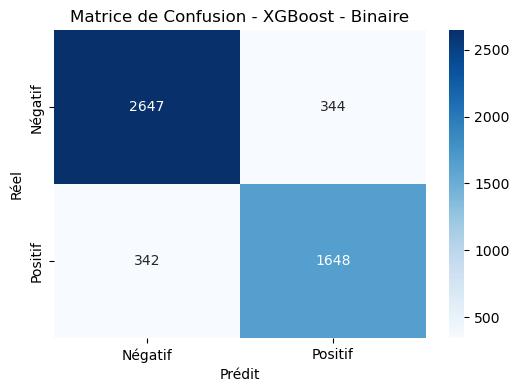

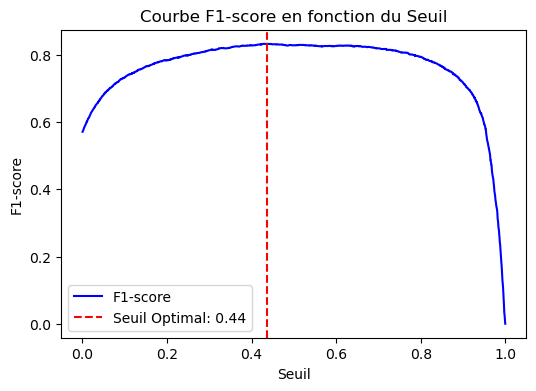

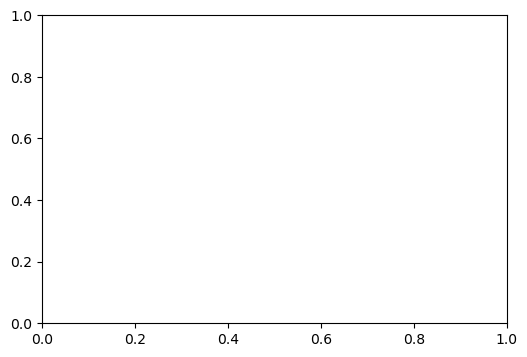

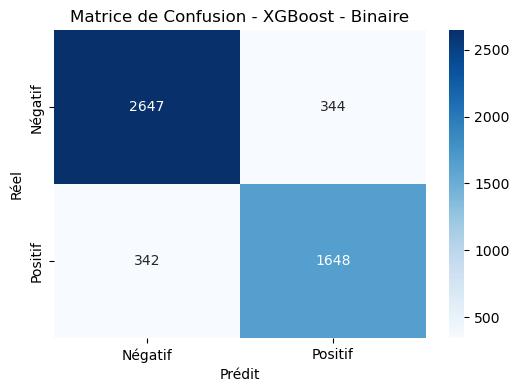

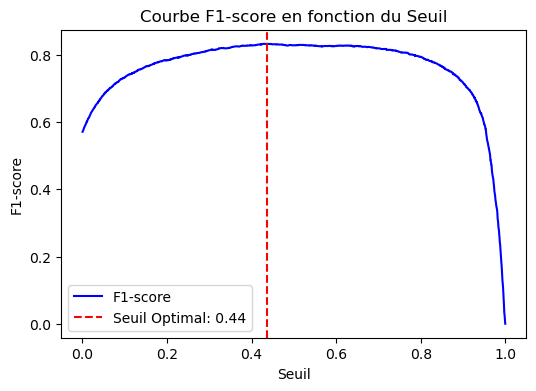

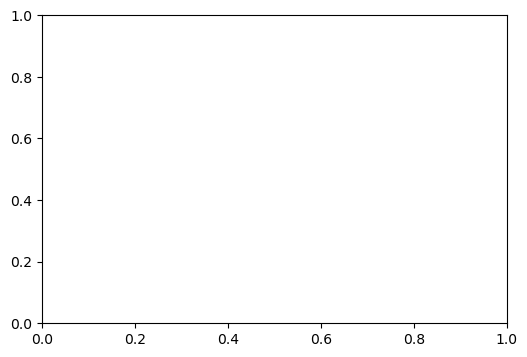

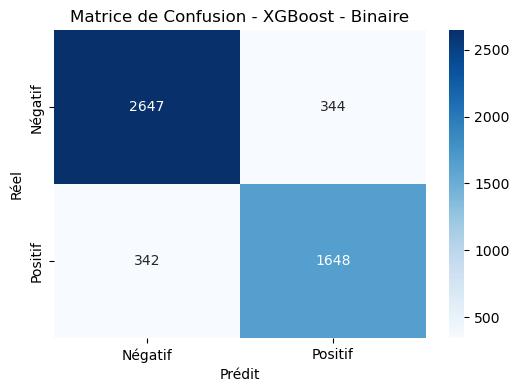

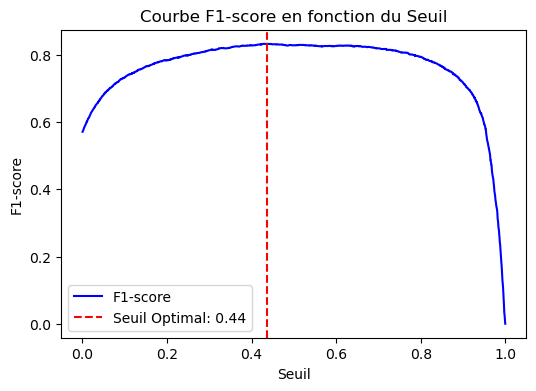

<Figure size 600x400 with 0 Axes>

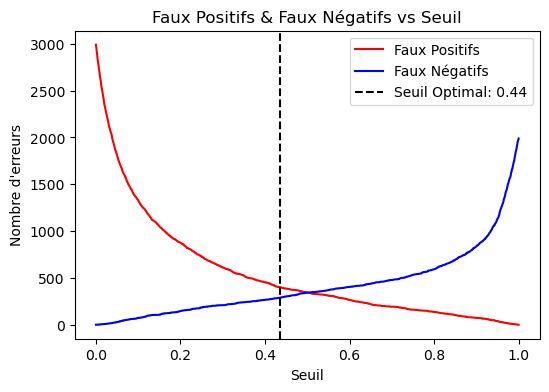

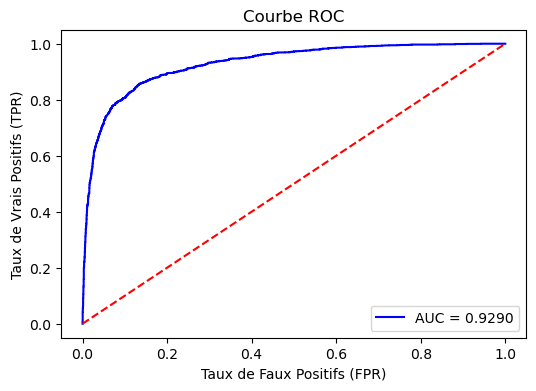

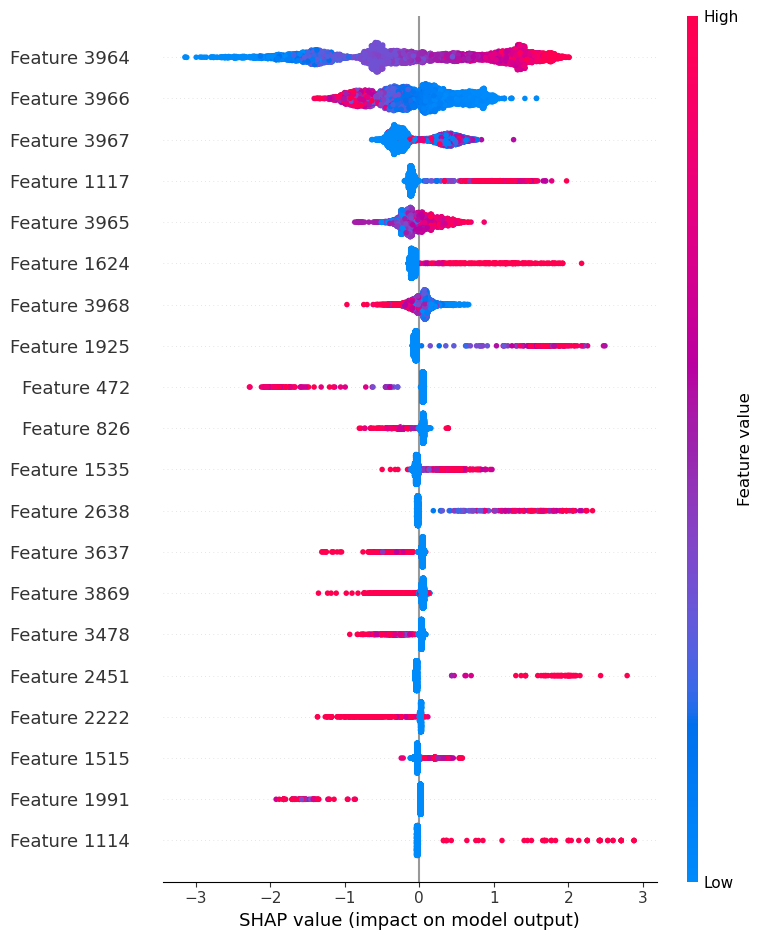

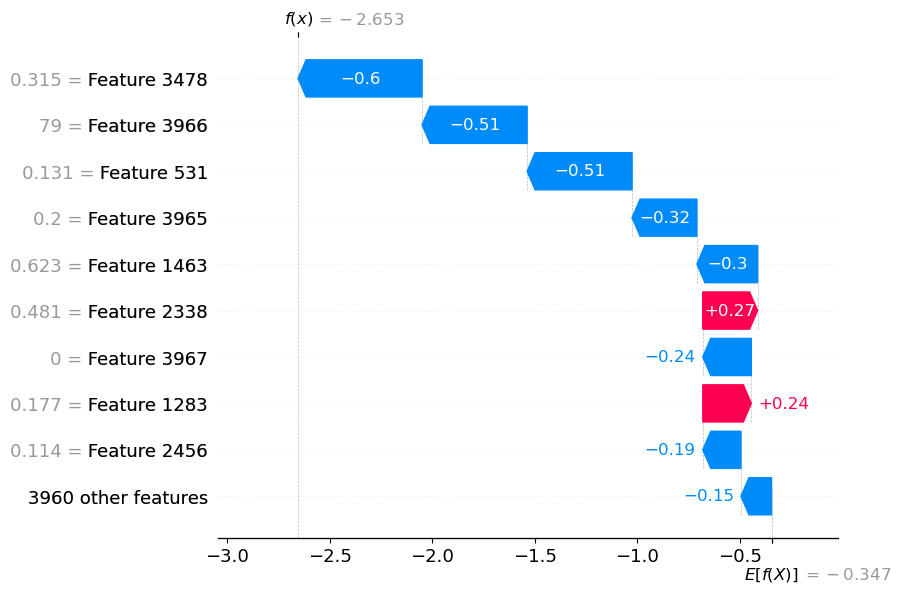

📌 XGBoost - Binaire Accuracy: 0.8623, AUC: 0.9290
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2991
           1       0.83      0.83      0.83      1990

    accuracy                           0.86      4981
   macro avg       0.86      0.86      0.86      4981
weighted avg       0.86      0.86      0.86      4981



2025/03/06 21:12:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🔹 Longueur de thresholds : 4741
🔹 Longueur de false_positives : 4741
🔹 Longueur de false_negatives : 4741
📌 RandomForest - Binaire Accuracy: 0.8292, AUC: 0.8988
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2991
           1       0.76      0.83      0.79      1990

    accuracy                           0.83      4981
   macro avg       0.82      0.83      0.82      4981
weighted avg       0.83      0.83      0.83      4981



2025/03/06 21:12:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.42645378
Epoch 3, change: 0.27033392
Epoch 4, change: 0.19864922
Epoch 5, change: 0.16222822
Epoch 6, change: 0.13497449
Epoch 7, change: 0.11709144
Epoch 8, change: 0.10288178
Epoch 9, change: 0.09154588
Epoch 10, change: 0.08243616
Epoch 11, change: 0.07479415
Epoch 12, change: 0.06834164
Epoch 13, change: 0.06282963
Epoch 14, change: 0.05806784
Epoch 15, change: 0.05390796
Epoch 16, change: 0.05022190
Epoch 17, change: 0.04695581
Epoch 18, change: 0.04401700
Epoch 19, change: 0.04141004
Epoch 20, change: 0.03904597
Epoch 21, change: 0.03689551
Epoch 22, change: 0.03493253
Epoch 23, change: 0.03313363
Epoch 24, change: 0.03149214
Epoch 25, change: 0.02996043
Epoch 26, change: 0.02883946
Epoch 27, change: 0.02796319
Epoch 28, change: 0.02714394
Epoch 29, change: 0.02637593
Epoch 30, change: 0.02565947
Epoch 31, change: 0.02499078
Epoch 32, change: 0.02436355
Epoch 33, change: 0.02377186
Epoch 34, change: 0.02321739
Epoch 35, change: 0.022

/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished


🔹 Longueur de thresholds : 4922
🔹 Longueur de false_positives : 4922
🔹 Longueur de false_negatives : 4922
📌 Logistic Regression - Binaire Accuracy: 0.6804, AUC: 0.8298
              precision    recall  f1-score   support

           0       0.84      0.57      0.68      2991
           1       0.57      0.84      0.68      1990

    accuracy                           0.68      4981
   macro avg       0.71      0.71      0.68      4981
weighted avg       0.73      0.68      0.68      4981



In [ ]:
import mlflow
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_auc_score, roc_curve
)

models = {
    "XGBoost - Binaire": xgb.XGBClassifier(n_estimators=200, max_depth=6, scale_pos_weight=len(y_train_bin[y_train_bin == 0]) / len(y_train_bin[y_train_bin == 1]), use_label_encoder=False, eval_metric="logloss", random_state=42),
    "RandomForest - Binaire": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression - Binaire": LogisticRegression(max_iter=200, solver="saga", class_weight="balanced", n_jobs=-1, verbose=1),
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train_bin, y_train_bin)

        y_pred = model.predict(X_test_bin)
        y_probs = model.predict_proba(X_test_bin)[:, 1]  # Probabilités pour le seuil

        #Calcul des métriques principales
        accuracy = accuracy_score(y_test_bin, y_pred)
        roc_auc = roc_auc_score(y_test_bin, y_probs)

        #Matrice de confusion
        conf_matrix = confusion_matrix(y_test_bin, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()


        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
        plt.xlabel("Prédit")
        plt.ylabel("Réel")
        plt.title(f"Matrice de Confusion - {name}")
        plt.savefig(f"{name}_confusion_matrix.png")  
        mlflow.log_artifact(f"{name}_confusion_matrix.png")

        #Courbe Precision-Recall et Seuil Optimal
        precision, recall, thresholds = precision_recall_curve(y_test_bin, y_probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  
        best_threshold = thresholds[np.argmax(f1_scores)]

        plt.figure(figsize=(6, 4))
        plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="blue")
        plt.axvline(best_threshold, color="red", linestyle="--", label=f"Seuil Optimal: {best_threshold:.2f}")
        plt.xlabel("Seuil")
        plt.ylabel("F1-score")
        plt.title("Courbe F1-score en fonction du Seuil")
        plt.legend()
        plt.savefig(f"{name}_threshold_curve.png")  
        mlflow.log_artifact(f"{name}_threshold_curve.png")

        # FP / FN
        false_positives = []
        false_negatives = []
        for t in thresholds:
            y_thresh = (y_probs >= t).astype(int)
            conf_matrix_thresh = confusion_matrix(y_test_bin, y_thresh)
            _, fp_t, fn_t, _ = conf_matrix_thresh.ravel()
            false_positives.append(fp_t)
            false_negatives.append(fn_t)
            
        plt.figure(figsize=(6, 4))

        #Verif
        print(f"🔹 Longueur de thresholds : {len(thresholds)}")
        print(f"🔹 Longueur de false_positives : {len(false_positives)}")
        print(f"🔹 Longueur de false_negatives : {len(false_negatives)}")

        min_length = min(len(thresholds), len(false_positives), len(false_negatives))

        #Traçage des courbes
        plt.plot(thresholds[:min_length], false_positives[:min_length], label="Faux Positifs", color="red")
        plt.plot(thresholds[:min_length], false_negatives[:min_length], label="Faux Négatifs", color="blue")

        #Seuil opti
        plt.axvline(best_threshold, color="black", linestyle="--", label=f"Seuil Optimal: {best_threshold:.2f}")
        plt.xlabel("Seuil")
        plt.ylabel("Nombre d'erreurs")
        plt.title("Faux Positifs & Faux Négatifs vs Seuil")
        plt.legend()
        plt.savefig(f"{name}_fp_fn_threshold.png")  
        mlflow.log_artifact(f"{name}_fp_fn_threshold.png")

        fpr, tpr, _ = roc_curve(y_test_bin, y_probs)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], color="red", linestyle="--")
        plt.xlabel("Taux de Faux Positifs (FPR)")
        plt.ylabel("Taux de Vrais Positifs (TPR)")
        plt.title("Courbe ROC")
        plt.legend()
        plt.savefig(f"{name}_roc_curve.png")  
        mlflow.log_artifact(f"{name}_roc_curve.png")

        #Log dans MLflow
        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", max(f1_scores))
        mlflow.log_metric("best_threshold", best_threshold)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("roc_auc", roc_auc)

        #Analyse avec Shape
        if "XGBoost" in name:
            explainer = shap.Explainer(model, X_train_bin)
            shap_values = explainer(X_test_bin)

            #Shap Global
            plt.figure(figsize=(8, 6))
            shap.summary_plot(shap_values, X_test_bin, show=False)
            plt.savefig(f"{name}_shap_global.png")  
            mlflow.log_artifact(f"{name}_shap_global.png")

            #Shap Local
            plt.figure(figsize=(8, 6))
            shap.plots.waterfall(shap_values[0])
            plt.savefig(f"{name}_shap_local.png")  
            mlflow.log_artifact(f"{name}_shap_local.png")

        print(f"📌 {name} Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")
        print(classification_report(y_test_bin, y_pred))

In [ ]:
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42,scale_pos_weight=len(y_train_bin[y_train_bin == 0]) / len(y_train_bin[y_train_bin == 1]), thresholds=0.44)

param_grid = {
    "n_estimators": [50, 100, 200],  # Nombre d'arbres
    "max_depth": [3, 6, 9],  # Profondeur des arbres
    "learning_rate": [0.01, 0.1, 0.3],  # Taux d'apprentissage
}
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2 #logs
)

with mlflow.start_run(run_name="XGBoost_GridSearch"):
    grid_search.fit(X_train_bin, y_train_bin)

    best_xgb = grid_search.best_estimator_
    y_pred = best_xgb.predict(X_test_bin)

    accuracy = grid_search.best_score_
    report = classification_report(y_test_bin, y_pred, output_dict=True)
    
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("Best Accuracy", accuracy)

    mlflow.sklearn.log_model(best_xgb, "XGBoost_Best_Model")

    conf_matrix = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.title("Matrice de confusion XGBoost")

    plt.savefig("conf_matrix_xgboost.png")
    mlflow.log_artifact("conf_matrix_xgboost.png")

    print(f"📌 Meilleurs paramètres : {grid_search.best_params_}")
    print(f"📊 Meilleure accuracy obtenue : {accuracy:.4f}")
    print(classification_report(y_test_bin, y_pred))

2025/03/12 00:08:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_e

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  27.8s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  28.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  28.5s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=6, n_estimators=50; total time=  36.3s
[CV] END ...learning_rate=0.01, max_depth=6, n_estimators=50; total time=  37.5s
[CV] END ...learning_rate=0.01, max_depth=6, n_estimators=50; total time=  37.5s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:08:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  47.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  47.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  47.9s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.4min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.5min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time= 1.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time= 1.1min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=9, n_estimators=50; total time=  46.8s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time= 1.1min
[CV] END ...learning_rate=0.01, max_depth=9, n_estimators=50; total time=  46.6s
[CV] END ...learning_rate=0.01, max_depth=9, n_estimators=50; total time=  48.4s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:09:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_e

[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  25.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  26.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  24.5s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  37.4s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  37.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  37.9s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time= 2.1min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time= 2.2min
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time= 2.2min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=50; total time=  32.1s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=50; total time=  31.3s
[CV] END ....learning_rate=0.1, max_depth=6, n_estimators=50; total time=  32.3s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time= 2.0min
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time= 2.0min
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=100; total time= 2.1min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 1.1min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  45.5s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  45.6s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  45.4s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  42.0s
[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  41.9s
[CV] END ....learning_rate=0.1, max_depth=9, n_estimators=50; total time=  45.4s


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 1.2min
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=200; total time= 1.2min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:12:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=  20.0s
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time=  19.5s
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=100; total time= 8.1min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=100; total time= 8.1min
[CV] END ....learning_rate=0.3, max_depth=3, n_estimators=50; total time= 7.4min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=100; total time= 8.1min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=200; total time=10.7min
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=200; total time=10.7min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_e

[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=200; total time=10.8min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.3, max_depth=6, n_estimators=50; total time= 6.4min
[CV] END ....learning_rate=0.3, max_depth=6, n_estimators=50; total time= 6.5min
[CV] END ....learning_rate=0.3, max_depth=6, n_estimators=50; total time= 6.4min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time=13.7min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:28:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time=15.8min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:29:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:29:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=100; total time= 8.7min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:29:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=200; total time=23.9min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=200; total time=23.9min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=200; total time=23.9min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:36:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:36:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=21.6min
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=23.2min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=100; total time=16.7min
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=200; total time=23.2min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=100; total time=16.7min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=100; total time=16.7min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:43:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:43:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:46:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_e

[CV] END ....learning_rate=0.3, max_depth=9, n_estimators=50; total time=10.5min
[CV] END ....learning_rate=0.3, max_depth=9, n_estimators=50; total time=10.5min
[CV] END ....learning_rate=0.3, max_depth=9, n_estimators=50; total time=10.5min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=200; total time=36.0min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=200; total time=35.9min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=200; total time=35.9min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=100; total time=21.5min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=100; total time=23.9min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=100; total time=22.3min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=200; total time=28.2min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=200; total time=28.2min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=200; total time=28.2min


/Users/baptiste/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:23:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "thresholds", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/03/12 01:28:24 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.


📌 Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
📊 Meilleure accuracy obtenue : 0.9248
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2991
           1       0.83      0.83      0.83      1990

    accuracy                           0.86      4981
   macro avg       0.86      0.86      0.86      4981
weighted avg       0.86      0.86      0.86      4981

